# LIBRARIES IMPORT

In [1]:
import CNN_lib
import CNN_utilities
import fig_lib 

import numpy as np
import matplotlib.pyplot as plt

import pickle
import json

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

# SETTINGS

In [2]:
save_dict_test = True

# ------------ CHECKING ------------

train_plots= True
rock_curves= True
checking_on=False

check_record_1= '670615_19'
check_record_2= 'ROT_670615_19'
t_btw_frm=0.05

In [3]:
mdl = 'Test E'
data_split='rnd_patients'                       # 'rnd_recs' 'rnd_patients'

trains_n=2
epochs=2

opt='adam'    #'adam','sgd' 
lss='binary_crossentropy'

conv_str_s = (1, 2, 2)  
conv_str_t = (2, 1, 1)  
pool_str = (1, 2, 2)  

### DATA SPLIT

In [4]:
if data_split == 'rnd_recs': test_size=0.2           

elif data_split == 'rnd_patients': val_pat_0,val_pat_1 = 12 , 6

### DATA AUGMENTATION

In [5]:
n_flip_1,n_flip_0=0.7 , 0.07
n_rot_1,n_rot_0=0.6 , 0.06
n_contr_1,n_contr_0=0.4 , 0.04
n_bright_1,n_bright_0=0.3 , 0.03

aug_params={'f1':n_flip_1,'f0':n_flip_0,'r1':n_rot_1,'r0':n_rot_0,'c1':n_contr_1,'c0':n_contr_0,'b1':n_bright_1,'b0':n_bright_0}

### PATHS

In [6]:

checkpoint_path = "C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/MODEL_ARCHITECTURE_CHECKPOINTS/chP"
pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/processed_train_d.pkl'   
pkl_models_d_p = 'C:\PROJECTS\EMBOENDO\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/models.pkl'

if data_split == 'rnd_patients': json_fix_sq_p='C:\PROJECTS\emboendo\dicom_viewer\_static\Jsons\points_fix_d.json'

In [7]:
models_d = {'model'+'_'+str(n):{'path':None,'name':None, 'model':None,'check_point':None, 'history':None, 'AUC':None,'Validation Recs':None,'Validation Patients ids':None} for n in range(trains_n)}

for n in range(trains_n):
    
    models_d['model'+'_'+str(n)]['path']=checkpoint_path+'_'+str(n)+'.h5'
    models_d['model'+'_'+str(n)]['name']='MODEL'+ ' ' + str(n)

for kk,vv in models_d.items(): print(kk,vv['path'])

model_0 C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/MODEL_ARCHITECTURE_CHECKPOINTS/chP_0.h5
model_1 C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/MODEL_ARCHITECTURE_CHECKPOINTS/chP_1.h5


# GENERATE TRAIN DATA

In [8]:
if data_split == 'rnd_patients':

    with open(json_fix_sq_p, 'r') as json_file:
        json_d = json.load(json_file)

    patients_d_df =  CNN_utilities.gen_patients_d_df(json_d)

In [9]:
with open(pkl_train_p, 'rb') as pikle_file:

    save_trains= pickle.load(pikle_file)

x_train,y_train,rcs =  save_trains[0],save_trains[1],save_trains[2]

max_frm_n , HEIGHT , WIDTH = np.shape(x_train)[1],np.shape(x_train)[2],np.shape(x_train)[3]
input_shape=(max_frm_n, HEIGHT, WIDTH, 1)

### MODEL

In [10]:
input_shape=(max_frm_n, HEIGHT, WIDTH, 1)

for kk in models_d.keys():

  model = models.Sequential([
            layers.Conv3D(filters=32, kernel_size=(1, 3, 3), activation='relu',input_shape=input_shape,strides=conv_str_s),
            layers.MaxPooling3D(pool_size=(1, 2, 2)),
            layers.Conv3D(filters=32, kernel_size=(1, 3, 3),  activation='relu',strides=conv_str_s),
            layers.MaxPooling3D(pool_size=(1, 2, 2)),
            layers.Conv3D(filters=64, kernel_size=(1, 3, 3),  activation='relu'),
            layers.MaxPooling3D(pool_size=(2, 1, 1)),
            layers.Conv3D(filters=128, kernel_size=(8, 1, 1),  activation='relu',strides=conv_str_t),
            layers.MaxPooling3D(pool_size=(2, 2, 2)),
            layers.Flatten(),
            layers.Dropout(0.4),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(32, activation='relu'),
            layers.Dense(1,activation='sigmoid')])

  
  model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])

  models_d[kk]['model']=model

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 40, 79, 79, 32)    320       
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 40, 39, 39, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 40, 19, 19, 32)    9248      
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 40, 9, 9, 32)      0         
 g3D)                                                            
                                                                 
 conv3d_6 (Conv3D)           (None, 40, 7, 7, 64)      18496     
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 20, 7, 7, 64)   

In [11]:
for kk,vv in models_d.items(): models_d[kk]['check_point']=ModelCheckpoint(vv['path'], save_best_only=True, monitor='val_loss',   mode='min', verbose=1)

### DATA INPUT CHECK 

In [12]:
if checking_on:

    for x,y,r in zip(x_train,y_train,rcs):print(r,int(y),np.shape(x),type(x))

In [13]:
if checking_on: CNN_utilities.simple_check(check_record_1,rcs,x_train,y_train)

#  CNN TRAINNING

In [14]:
iter=0

for kk,vv in models_d.items():

    X_d,Y_d,recs=CNN_lib.shuffle(x_train,y_train,rcs)                                                                                                                                                      # SHUFFLE

    if data_split=='rnd_recs': X_train_spl, X_eval_spl, Y_train_spl, Y_eval_spl ,recs_train,recs_eval=CNN_utilities.random_split_by_recs(X_d, Y_d,recs, test_size=test_size)                               # SPLIT
    else: X_train_spl, X_eval_spl, Y_train_spl, Y_eval_spl ,recs_train,recs_eval, patients_eval_id=CNN_utilities.random_split_by_patients(patients_d_df,recs,X_d,Y_d, val_pat_0=val_pat_0, val_pat_1=val_pat_1)

    X_eval,Y_eval,r_eval=CNN_lib.shuffle(X_eval_spl,Y_eval_spl,recs_eval)                                                                                                                                   # SHUFFLE EVAL
    
    if checking_on: CNN_utilities.in_loop_check(check_record_1,recs_train,X_train_spl,Y_train_spl)                                                                                                          # CHECK

    X_train_spl, Y_train_spl, recs_train = CNN_lib.d_augmentation_logic_encapsulation(X_train_spl,Y_train_spl,recs_train,aug_params)                                                                        # AUGMENTATION

    X_train,Y_train,recs_train_f=CNN_lib.shuffle(X_train_spl,Y_train_spl,recs_train)                                                                                                                        # SHUFFLE
    
    if checking_on: CNN_utilities.in_loop_check(check_record_2,recs_train_f,X_train,Y_train)                                                                                                                # CHECK

    hist=vv['model'].fit(X_train, Y_train, epochs=epochs, validation_data=(X_eval,Y_eval),callbacks=[vv['check_point']],verbose=0)  
    
    models_d[kk]['Validation Recs'] = recs_eval
    if data_split=='rnd_patients':models_d[kk]['Validation Patients ids'] = patients_eval_id                                                                                                     # TRAIN
    models_d[kk]['history'] = hist
    
    
    iter+=1
    print(' ')
    print(f'-------------- ITERATION {iter}/{trains_n} COMPLETED --------------')




Epoch 1: val_loss improved from inf to 0.68334, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/MODEL_ARCHITECTURE_CHECKPOINTS\chP_0.h5


c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.68334
 
-------------- ITERATION 1/2 COMPLETED --------------

Epoch 1: val_loss improved from inf to 0.68220, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/MODEL_ARCHITECTURE_CHECKPOINTS\chP_1.h5

Epoch 2: val_loss improved from 0.68220 to 0.67689, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/MODEL_ARCHITECTURE_CHECKPOINTS\chP_1.h5
 
-------------- ITERATION 2/2 COMPLETED --------------


In [15]:
for kk,vv in models_d.items(): models_d[kk]['model'] = load_model(vv['path'])

# EVALUATE MODEL

Name: MODEL 0 Path: C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/MODEL_ARCHITECTURE_CHECKPOINTS/chP_0.h5


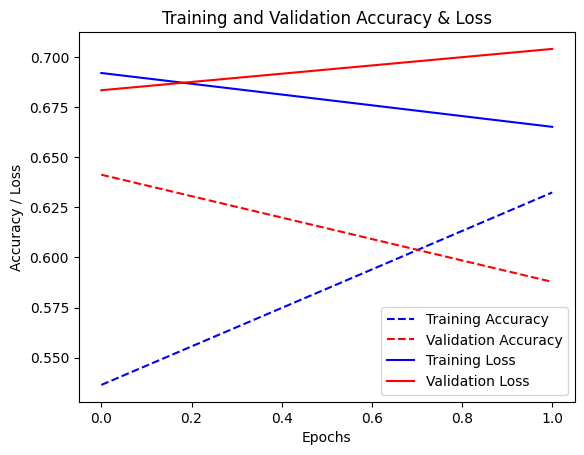

Name: MODEL 1 Path: C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/MODEL_ARCHITECTURE_CHECKPOINTS/chP_1.h5


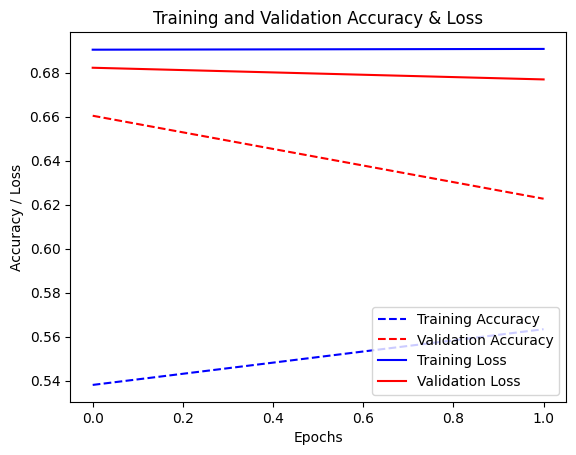

In [16]:
if train_plots:

    for vv in models_d.values():
    
        print('Name:',vv['name'], 'Path:',vv['path'])
        CNN_lib.plot_train_eval(vv['history'],epochs,type='together')

In [17]:
loss,accuracy= [],[]

for vv in models_d.values():

    test_loss, test_accuracy = vv['model'].evaluate(X_eval,Y_eval,verbose=0) 

    loss.append(test_loss)
    accuracy.append(test_accuracy)

# ROC CURVE

C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/MODEL_ARCHITECTURE_CHECKPOINTS/chP_0.h5
5/5 [==============================] - 1s 73ms/step


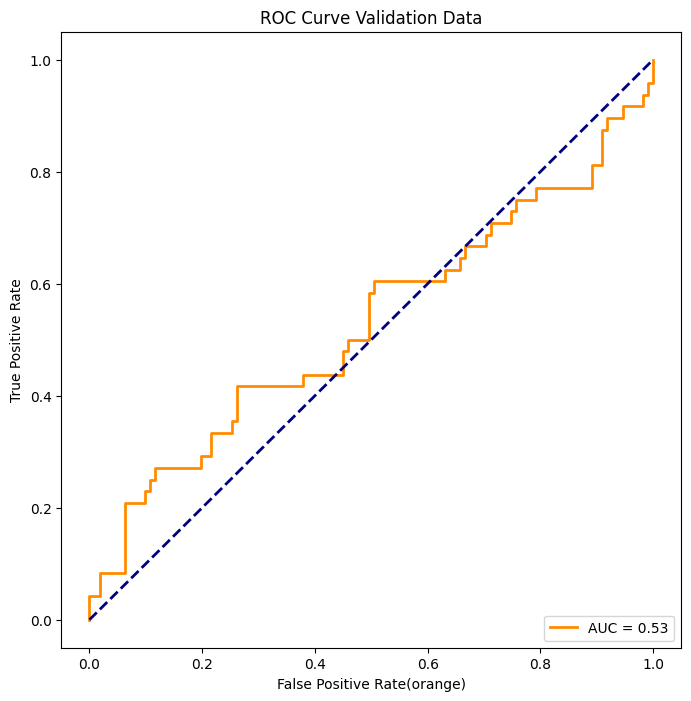

C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/MODEL_ARCHITECTURE_CHECKPOINTS/chP_1.h5
5/5 [==============================] - 0s 75ms/step


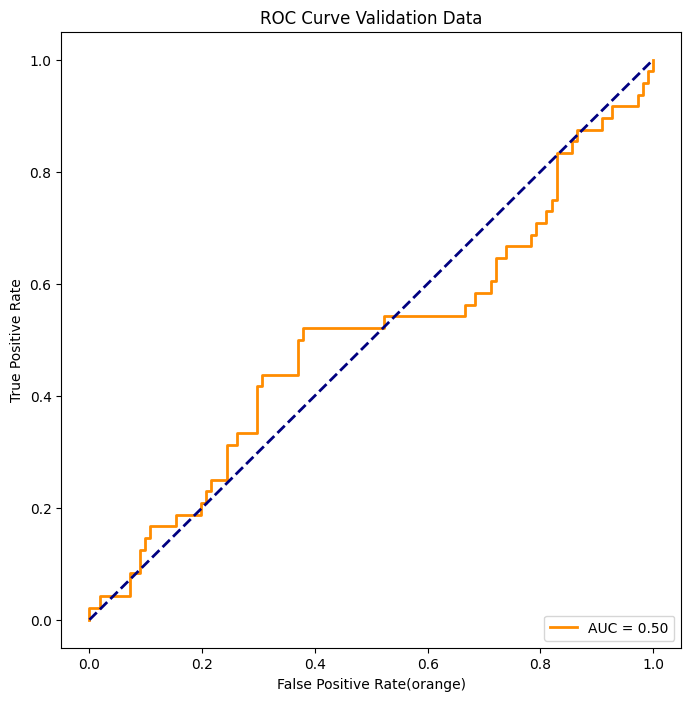

In [18]:
roc_aucs = []
prediction_ls=[]

for kk , vv in models_d.items():

    print(vv['path'])
    predictions = vv['model'].predict(X_eval)

    fpr_val, tpr_val, thresholds_val = roc_curve(Y_eval, predictions)
    roc_auc_false = auc(fpr_val, tpr_val)

    prediction_ls.append(predictions)
    roc_aucs.append(roc_auc_false)
    models_d[kk]['AUC']=roc_auc_false

    if rock_curves:CNN_lib.plot_roc_curve(fpr_val,tpr_val,roc_auc_false)

# TEST RESULTS

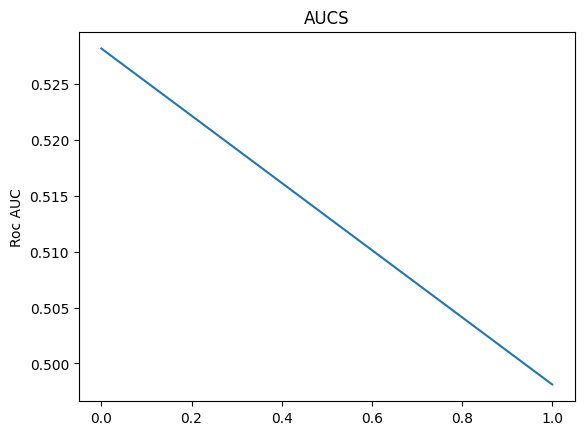

In [19]:
CNN_lib.list_plot(roc_aucs,title='AUCS',ylabel='Roc AUC')

In [20]:
CNN_lib.stats(roc_aucs,title='AUC')
CNN_lib.stats(loss,title='LOSS')
CNN_lib.stats(accuracy,title='ACCURACITY',rnd=4)

 
AUC :
Valor medio:0.513
Desviación estandar:0.015
Varianza:0.0
Máximo:0.528
Mínimo:0.498
Mediana:0.513
Percentil 25:0.506
Percentil 75:0.521
 
LOSS :
Valor medio:0.675
Desviación estandar:0.002
Varianza:0.0
Máximo:0.677
Mínimo:0.674
Mediana:0.675
Percentil 25:0.675
Percentil 75:0.676
 
ACCURACITY :
Valor medio:0.6635
Desviación estandar:0.0409
Varianza:0.0017
Máximo:0.7044
Mínimo:0.6226
Mediana:0.6635
Percentil 25:0.6431
Percentil 75:0.684


#  SAVE TEST

In [21]:
if save_dict_test:

    CNN_utilities.save_data(pkl_models_d_p,models_d)

In [23]:
#models_d['model_0']['Validation Recs']
models_d['model_0']['Validation Patients ids']


array([   788,   1327,    800,   1340,   6272,    928,    781,   1044,
       547169,    953,    884,    954,    794,   1258,    789, 660022,
          136,    945])